In [3]:

from tensorflow import keras

data = keras.datasets.mnist.load_data()

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential

(X_train, y_train), (X_test, y_test) = data
X_train = X_train / 255
X_test = X_test / 255
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
# On va essayer de trouver la bonne valuer de learning rate

K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        lr = K.get_value(self.model.optimizer.lr)
        self.rates.append(lr)
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, lr * self.factor)

expon_lr = ExponentialLearningRate(factor=1.005)

test_pmc = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(100, activation="relu"),
    Dense(100, activation="relu"),
    Dense(10, activation="softmax")
])

test_pmc.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"], optimizer=keras.optimizers.SGD(lr=1e-3))
history = test_pmc.fit(X_train, y_train, epochs=1, validation_data=(X_val, y_val), callbacks=[expon_lr])



1500/1500 [==============================] - 3s 2ms/step - loss: 1.6595 - accuracy: 0.4765 - val_loss: 3.6898 - val_accuracy: 0.2330


Text(0.5, 1.0, 'argmax = 1.2026526927947998')

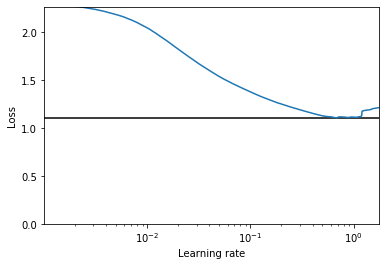

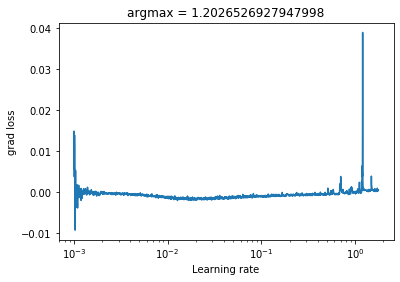

In [10]:
import numpy as np
import matplotlib.pyplot as plt

grad_losses = [expon_lr.losses[i+1] - expon_lr.losses[i] for i in range(len(expon_lr.losses) - 1)]
grad_losses.append(grad_losses[-1])

plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")

plt.figure()
plt.gca().set_xscale('log')
# plt.gca().set_yscale('log')

grad_losses = np.array(grad_losses)
grad_losses[np.abs(grad_losses) > 10] = 0
plt.plot(expon_lr.rates, grad_losses)
plt.xlabel("Learning rate")
plt.ylabel("grad loss")
plt.title(f"argmax = {expon_lr.rates[np.argmax(grad_losses)]}")

In [11]:

pmc = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(100, activation="relu"),
    Dense(100, activation="relu"),
    Dense(10, activation="softmax")
])
pmc.summary()

pmc.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"], optimizer=keras.optimizers.SGD(lr=2e-1))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [12]:
checkpoints = keras.callbacks.ModelCheckpoint("my_pmc_model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

import os
root = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root, run_id)

tsboard = keras.callbacks.TensorBoard(get_run_logdir())
history = pmc.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[checkpoints, early_stopping, tsboard])

Epoch 1/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4744 - accuracy: 0.8558 - val_loss: 0.1530 - val_accuracy: 0.9534
Epoch 2/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1232 - accuracy: 0.9623 - val_loss: 0.1165 - val_accuracy: 0.9638
Epoch 3/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0843 - accuracy: 0.9743 - val_loss: 0.1088 - val_accuracy: 0.9672
Epoch 4/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0622 - accuracy: 0.9803 - val_loss: 0.1009 - val_accuracy: 0.9719
Epoch 5/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0458 - accuracy: 0.9856 - val_loss: 0.0910 - val_accuracy: 0.9729
Epoch 6/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0371 - accuracy: 0.9881 - val_loss: 0.1071 - val_accuracy: 0.9698
Epoch 7/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0299 - accuracy: 0.9901 - val_loss: 0.1041 - val_ac

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

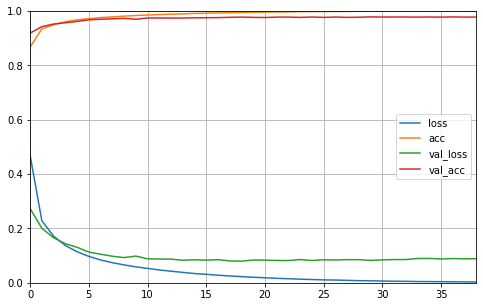

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure()
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid()
    plt.gca().set_ylim(0,1)
    plt.show()
plot_history(history)

In [72]:
pmc.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 19us/sample - loss: 0.0936 - acc: 0.9807


[0.09361895046967124, 0.9807]

In [126]:
# Tentative de trouver les paramètres par GridSearch
def build_model(n_hidden=2, n_neurons=30, learning_rate=3e-3):
    model = keras.models.Sequential([
        Flatten(input_shape=[28, 28]),
    ])
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation="relu"))
    model.add(Dense(10, activation="softmax"))

    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"], optimizer=optimizer)
    return model


In [129]:
# from sklearn.model_selection import GridSearchCV
# from scipy.stats import reciprocal

# param_distribs = {
#     "n_hidden": [1, 2, 3],
#     "n_neurons": [100, 200, 300],
#     "learning_rate": [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1],
# }
# keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)
# rnd_search_cv = GridSearchCV(keras_reg, param_distribs, cv=3, refit=True, verbose=2)
# rnd_search_cv.fit(X_train, y_train, epochs=100,
#                   validation_data=(X_val, y_val),
#                   callbacks=[keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)])

Fitting 3 folds for each of 63 candidates, totalling 189 fits
[CV] learning_rate=0.001, n_hidden=1, n_neurons=100 ..................
Train on 32000 samples, validate on 12000 samples
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Epoch 1/100
32000/32000 [==============================] - 2s 70us/sample - loss: 1.9868 - acc: 0.4202 - val_loss: 1.6413 - val_acc: 0.6579
Epoch 2/100
32000/32000 [==============================] - 1s 46us/sample - loss: 1.3649 - acc: 0.7365 - val_loss: 1.1489 - val_acc: 0.7812
Epoch 3/100
32000/32000 [==============================] - 2s 53us/sample - loss: 0.9961 - acc: 0.8028 - val_loss: 0.8859 - val_acc: 0.8164
Epoch 4/100
32000/32000 [==============================] - 2s 49us/sample - loss: 0.7999 - acc: 0.8294 - val_loss: 0.7410 - val_acc: 0.8356
Epoch 5/100
32000/32000 [==============================] - 2s 50us/sample - loss: 0.6865 - acc: 0.8440 - val_loss: 0.6515 - val_acc: 0.8499
Epoch 6/100
32000/32000 [===========

KeyboardInterrupt: 

In [ ]:
rnd_search_cv.best_params

In [13]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.test.is_built_with_cuda())

print(tf.test.is_gpu_available())

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

print(tf.test.gpu_device_name())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9666715454055603477
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7189784192
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4997292588800460205
physical_device_desc: "device: 0, name: GeForce GTX 1070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
True
True
Num GPUs Available:  1
/device:GPU:0
